<!-- dom:TITLE: Data Analysis and Machine Learning: Logistic Regression -->
# Data Analysis and Machine Learning: Logistic Regression
<!-- dom:AUTHOR: Morten Hjorth-Jensen at Department of Physics, University of Oslo & Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University -->
<!-- Author: -->  
**Morten Hjorth-Jensen**, Department of Physics, University of Oslo and Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University

Date: **Sep 18, 2020**

Copyright 1999-2020, Morten Hjorth-Jensen. Released under CC Attribution-NonCommercial 4.0 license




## Plans for week 38

* Thursday: Summary of regression methods and discussion of project 1. We revisit also cross-validation and bootstrap as resampling techniques with examples

* Friday: Logistic Regression

## Thursday September 17

[Video of Lecture](https://www.uio.no/studier/emner/matnat/fys/FYS-STK4155/h20/forelesningsvideoer/LectureSeptember17.mp4?vrtx=view-as-webpage) and [link to handwritten notes](https://github.com/CompPhysics/MachineLearning/blob/master/doc/HandWrittenNotes/NotesSeptember17.pdf).

## Ridge and LASSO Regression, reminder

The expression for the standard Mean Squared Error (MSE) which we used to define our cost function and the equations for the ordinary least squares (OLS) method, that is 
our optimization problem is

$$
{\displaystyle \min_{\boldsymbol{\beta}\in {\mathbb{R}}^{p}}}\frac{1}{n}\left\{\left(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}\right)^T\left(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}\right)\right\}.
$$

or we can state it as

$$
{\displaystyle \min_{\boldsymbol{\beta}\in
{\mathbb{R}}^{p}}}\frac{1}{n}\sum_{i=0}^{n-1}\left(y_i-\tilde{y}_i\right)^2=\frac{1}{n}\vert\vert \boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}\vert\vert_2^2,
$$

where we have used the definition of  a norm-2 vector, that is

$$
\vert\vert \boldsymbol{x}\vert\vert_2 = \sqrt{\sum_i x_i^2}.
$$

By minimizing the above equation with respect to the parameters
$\boldsymbol{\beta}$ we could then obtain an analytical expression for the
parameters $\boldsymbol{\beta}$.  We can add a regularization parameter $\lambda$ by
defining a new cost function to be optimized, that is

$$
{\displaystyle \min_{\boldsymbol{\beta}\in
{\mathbb{R}}^{p}}}\frac{1}{n}\vert\vert \boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}\vert\vert_2^2+\lambda\vert\vert \boldsymbol{\beta}\vert\vert_2^2
$$

which leads to the Ridge regression minimization problem where we
require that $\vert\vert \boldsymbol{\beta}\vert\vert_2^2\le t$, where $t$ is
a finite number larger than zero. By defining

$$
C(\boldsymbol{X},\boldsymbol{\beta})=\frac{1}{n}\vert\vert \boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}\vert\vert_2^2+\lambda\vert\vert \boldsymbol{\beta}\vert\vert_1,
$$

we have a new optimization equation

$$
{\displaystyle \min_{\boldsymbol{\beta}\in
{\mathbb{R}}^{p}}}\frac{1}{n}\vert\vert \boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}\vert\vert_2^2+\lambda\vert\vert \boldsymbol{\beta}\vert\vert_1
$$

which leads to Lasso regression. Lasso stands for least absolute shrinkage and selection operator. 

Here we have defined the norm-1 as

$$
\vert\vert \boldsymbol{x}\vert\vert_1 = \sum_i \vert x_i\vert.
$$

<!-- !split  -->
## Various steps in cross-validation

When the repetitive splitting of the data set is done randomly,
samples may accidently end up in a fast majority of the splits in
either training or test set. Such samples may have an unbalanced
influence on either model building or prediction evaluation. To avoid
this $k$-fold cross-validation structures the data splitting. The
samples are divided into $k$ more or less equally sized exhaustive and
mutually exclusive subsets. In turn (at each split) one of these
subsets plays the role of the test set while the union of the
remaining subsets constitutes the training set. Such a splitting
warrants a balanced representation of each sample in both training and
test set over the splits. Still the division into the $k$ subsets
involves a degree of randomness. This may be fully excluded when
choosing $k=n$. This particular case is referred to as leave-one-out
cross-validation (LOOCV). 

<!-- !split  -->
## How to set up the cross-validation for Ridge and/or Lasso

* Define a range of interest for the penalty parameter.

* Divide the data set into training and test set comprising samples $\{1, \ldots, n\} \setminus i$ and $\{ i \}$, respectively.

* Fit the linear regression model by means of ridge estimation  for each $\lambda$ in the grid using the training set, and the corresponding estimate of the error variance $\boldsymbol{\sigma}_{-i}^2(\lambda)$, as

$$
\begin{align*}
\boldsymbol{\beta}_{-i}(\lambda) & =  ( \boldsymbol{X}_{-i, \ast}^{T}
\boldsymbol{X}_{-i, \ast} + \lambda \boldsymbol{I}_{pp})^{-1}
\boldsymbol{X}_{-i, \ast}^{T} \boldsymbol{y}_{-i}
\end{align*}
$$

* Evaluate the prediction performance of these models on the test set by $\log\{L[y_i, \boldsymbol{X}_{i, \ast}; \boldsymbol{\beta}_{-i}(\lambda), \boldsymbol{\sigma}_{-i}^2(\lambda)]\}$. Or, by the prediction error $|y_i - \boldsymbol{X}_{i, \ast} \boldsymbol{\beta}_{-i}(\lambda)|$, the relative error, the error squared or the R2 score function.

* Repeat the first three steps  such that each sample plays the role of the test set once.

* Average the prediction performances of the test sets at each grid point of the penalty bias/parameter. It is an estimate of the prediction performance of the model corresponding to this value of the penalty parameter on novel data. It is defined as

$$
\begin{align*}
\frac{1}{n} \sum_{i = 1}^n \log\{L[y_i, \mathbf{X}_{i, \ast}; \boldsymbol{\beta}_{-i}(\lambda), \boldsymbol{\sigma}_{-i}^2(\lambda)]\}.
\end{align*}
$$

## Cross-validation in brief

For the various values of $k$

1. shuffle the dataset randomly.

2. Split the dataset into $k$ groups.

3. For each unique group:

a. Decide which group to use as set for test data

b. Take the remaining groups as a training data set

c. Fit a model on the training set and evaluate it on the test set

d. Retain the evaluation score and discard the model


5. Summarize the model using the sample of model evaluation scores

## Code Example for Cross-validation and $k$-fold Cross-validation

The code here uses Ridge regression with cross-validation (CV)  resampling and $k$-fold CV in order to fit a specific polynomial.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(3155)

# Generate the data.
nsamples = 100
x = np.random.randn(nsamples)
y = 3*x**2 + np.random.randn(nsamples)

## Cross-validation on Ridge regression using KFold only

# Decide degree on polynomial to fit
poly = PolynomialFeatures(degree = 6)

# Decide which values of lambda to use
nlambdas = 500
lambdas = np.logspace(-3, 5, nlambdas)

# Initialize a KFold instance
k = 5
kfold = KFold(n_splits = k)

# Perform the cross-validation to estimate MSE
scores_KFold = np.zeros((nlambdas, k))

i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)
    j = 0
    for train_inds, test_inds in kfold.split(x):
        xtrain = x[train_inds]
        ytrain = y[train_inds]

        xtest = x[test_inds]
        ytest = y[test_inds]

        Xtrain = poly.fit_transform(xtrain[:, np.newaxis])
        ridge.fit(Xtrain, ytrain[:, np.newaxis])

        Xtest = poly.fit_transform(xtest[:, np.newaxis])
        ypred = ridge.predict(Xtest)

        scores_KFold[i,j] = np.sum((ypred - ytest[:, np.newaxis])**2)/np.size(ypred)

        j += 1
    i += 1


estimated_mse_KFold = np.mean(scores_KFold, axis = 1)

## Cross-validation using cross_val_score from sklearn along with KFold

# kfold is an instance initialized above as:
# kfold = KFold(n_splits = k)

estimated_mse_sklearn = np.zeros(nlambdas)
i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)

    X = poly.fit_transform(x[:, np.newaxis])
    estimated_mse_folds = cross_val_score(ridge, X, y[:, np.newaxis], scoring='neg_mean_squared_error', cv=kfold)

    # cross_val_score return an array containing the estimated negative mse for every fold.
    # we have to the the mean of every array in order to get an estimate of the mse of the model
    estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)

    i += 1

## Plot and compare the slightly different ways to perform cross-validation

plt.figure()

plt.plot(np.log10(lambdas), estimated_mse_sklearn, label = 'cross_val_score')
plt.plot(np.log10(lambdas), estimated_mse_KFold, 'r--', label = 'KFold')

plt.xlabel('log10(lambda)')
plt.ylabel('mse')

plt.legend()

plt.show()

## Bias-Variance tradeoff with Bootstrap

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

np.random.seed(2018)

n = 40
n_boostraps = 100
maxdegree = 14


# Make data set.
x = np.linspace(-3, 3, n).reshape(-1, 1)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.normal(0, 0.1, x.shape)
error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

for degree in range(maxdegree):
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False))
    y_pred = np.empty((y_test.shape[0], n_boostraps))
    for i in range(n_boostraps):
        x_, y_ = resample(x_train, y_train)
        y_pred[:, i] = model.fit(x_, y_).predict(x_test).ravel()

    polydegree[degree] = degree
    error[degree] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
    print('Polynomial degree:', degree)
    print('Error:', error[degree])
    print('Bias^2:', bias[degree])
    print('Var:', variance[degree])
    print('{} >= {} + {} = {}'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))

plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.legend()
plt.show()

## Another Example from Scikit-Learn's Repository

In [3]:
"""
============================
Underfitting vs. Overfitting
============================

This example demonstrates the problems of underfitting and overfitting and
how we can use linear regression with polynomial features to approximate
nonlinear functions. The plot shows the function that we want to approximate,
which is a part of the cosine function. In addition, the samples from the
real function and the approximations of different models are displayed. The
models have polynomial features of different degrees. We can see that a
linear function (polynomial with degree 1) is not sufficient to fit the
training samples. This is called **underfitting**. A polynomial of degree 4
approximates the true function almost perfectly. However, for higher degrees
the model will **overfit** the training data, i.e. it learns the noise of the
training data.
We evaluate quantitatively **overfitting** / **underfitting** by using
cross-validation. We calculate the mean squared error (MSE) on the validation
set, the higher, the less likely the model generalizes correctly from the
training data.
"""

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

## Cross-validation with Ridge

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

# A seed just to ensure that the random numbers are the same for every run.
np.random.seed(3155)
# Generate the data.
n = 100
x = np.linspace(-3, 3, n).reshape(-1, 1)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.normal(0, 0.1, x.shape)
# Decide degree on polynomial to fit
poly = PolynomialFeatures(degree = 10)

# Decide which values of lambda to use
nlambdas = 500
lambdas = np.logspace(-3, 5, nlambdas)
# Initialize a KFold instance
k = 5
kfold = KFold(n_splits = k)
estimated_mse_sklearn = np.zeros(nlambdas)
i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)
    estimated_mse_folds = cross_val_score(ridge, x, y, scoring='neg_mean_squared_error', cv=kfold)
    estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)
    i += 1
plt.figure()
plt.plot(np.log10(lambdas), estimated_mse_sklearn, label = 'cross_val_score')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

## The Ising model

The one-dimensional Ising model with nearest neighbor interaction, no
external field and a constant coupling constant $J$ is given by

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
    H = -J \sum_{k}^L s_k s_{k + 1},
\label{_auto1} \tag{1}
\end{equation}
$$

where $s_i \in \{-1, 1\}$ and $s_{N + 1} = s_1$. The number of spins
in the system is determined by $L$. For the one-dimensional system
there is no phase transition.

We will look at a system of $L = 40$ spins with a coupling constant of
$J = 1$. To get enough training data we will generate 10000 states
with their respective energies.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import scipy.linalg as scl
from sklearn.model_selection import train_test_split
import tqdm
sns.set(color_codes=True)
cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

L = 40
n = int(1e4)

spins = np.random.choice([-1, 1], size=(n, L))
J = 1.0

energies = np.zeros(n)

for i in range(n):
    energies[i] = - J * np.dot(spins[i], np.roll(spins[i], 1))

Here we use ordinary least squares
regression to predict the energy for the nearest neighbor
one-dimensional Ising model on a ring, i.e., the endpoints wrap
around. We will use linear regression to fit a value for
the coupling constant to achieve this.

## Reformulating the problem to suit regression

A more general form for the one-dimensional Ising model is

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation}
    H = - \sum_j^L \sum_k^L s_j s_k J_{jk}.
\label{_auto2} \tag{2}
\end{equation}
$$

Here we allow for interactions beyond the nearest neighbors and a state dependent
coupling constant. This latter expression can be formulated as
a matrix-product

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation}
    \boldsymbol{H} = \boldsymbol{X} J,
\label{_auto3} \tag{3}
\end{equation}
$$

where $X_{jk} = s_j s_k$ and $J$ is a matrix which consists of the
elements $-J_{jk}$. This form of writing the energy fits perfectly
with the form utilized in linear regression, that is

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation}
    \boldsymbol{y} = \boldsymbol{X}\boldsymbol{\beta} + \boldsymbol{\epsilon},
\label{_auto4} \tag{4}
\end{equation}
$$

We split the data in training and test data as discussed in the previous example

In [6]:
X = np.zeros((n, L ** 2))
for i in range(n):
    X[i] = np.outer(spins[i], spins[i]).ravel()
y = energies
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Linear regression

In the ordinary least squares method we choose the cost function

<!-- Equation labels as ordinary links -->
<div id="_auto5"></div>

$$
\begin{equation}
    C(\boldsymbol{X}, \boldsymbol{\beta})= \frac{1}{n}\left\{(\boldsymbol{X}\boldsymbol{\beta} - \boldsymbol{y})^T(\boldsymbol{X}\boldsymbol{\beta} - \boldsymbol{y})\right\}.
\label{_auto5} \tag{5}
\end{equation}
$$

We then find the extremal point of $C$ by taking the derivative with respect to $\boldsymbol{\beta}$ as discussed above.
This yields the expression for $\boldsymbol{\beta}$ to be

$$
\boldsymbol{\beta} = \frac{\boldsymbol{X}^T \boldsymbol{y}}{\boldsymbol{X}^T \boldsymbol{X}},
$$

which immediately imposes some requirements on $\boldsymbol{X}$ as there must exist
an inverse of $\boldsymbol{X}^T \boldsymbol{X}$. If the expression we are modeling contains an
intercept, i.e., a constant term, we must make sure that the
first column of $\boldsymbol{X}$ consists of $1$. We do this here

In [7]:
X_train_own = np.concatenate(
    (np.ones(len(X_train))[:, np.newaxis], X_train),
    axis=1
)
X_test_own = np.concatenate(
    (np.ones(len(X_test))[:, np.newaxis], X_test),
    axis=1
)

In [8]:
def ols_inv(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    return scl.inv(x.T @ x) @ (x.T @ y)
beta = ols_inv(X_train_own, y_train)

## Singular Value decomposition

Doing the inversion directly turns out to be a bad idea since the matrix
$\boldsymbol{X}^T\boldsymbol{X}$ is singular. An alternative approach is to use the **singular
value decomposition**. Using the definition of the Moore-Penrose
pseudoinverse we can write the equation for $\boldsymbol{\beta}$ as

$$
\boldsymbol{\beta} = \boldsymbol{X}^{+}\boldsymbol{y},
$$

where the pseudoinverse of $\boldsymbol{X}$ is given by

$$
\boldsymbol{X}^{+} = \frac{\boldsymbol{X}^T}{\boldsymbol{X}^T\boldsymbol{X}}.
$$

Using singular value decomposition we can decompose the matrix  $\boldsymbol{X} = \boldsymbol{U}\boldsymbol{\Sigma} \boldsymbol{V}^T$,
where $\boldsymbol{U}$ and $\boldsymbol{V}$ are orthogonal(unitary) matrices and $\boldsymbol{\Sigma}$ contains the singular values (more details below).
where $X^{+} = V\Sigma^{+} U^T$. This reduces the equation for
$\omega$ to

<!-- Equation labels as ordinary links -->
<div id="_auto6"></div>

$$
\begin{equation}
    \boldsymbol{\beta} = \boldsymbol{V}\boldsymbol{\Sigma}^{+} \boldsymbol{U}^T \boldsymbol{y}.
\label{_auto6} \tag{6}
\end{equation}
$$

Note that solving this equation by actually doing the pseudoinverse
(which is what we will do) is not a good idea as this operation scales
as $\mathcal{O}(n^3)$, where $n$ is the number of elements in a
general matrix. Instead, doing $QR$-factorization and solving the
linear system as an equation would reduce this down to
$\mathcal{O}(n^2)$ operations.

In [9]:
def ols_svd(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    u, s, v = scl.svd(x)
    return v.T @ scl.pinv(scl.diagsvd(s, u.shape[0], v.shape[0])) @ u.T @ y

In [10]:
beta = ols_svd(X_train_own,y_train)

When extracting the $J$-matrix  we need to make sure that we remove the intercept, as is done here

In [11]:
J = beta[1:].reshape(L, L)

A way of looking at the coefficients in $J$ is to plot the matrices as images.

In [12]:
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J, **cmap_args)
plt.title("OLS", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)
plt.show()

It is interesting to note that OLS
considers both $J_{j, j + 1} = -0.5$ and $J_{j, j - 1} = -0.5$ as
valid matrix elements for $J$.
In our discussion below on hyperparameters and Ridge and Lasso regression we will see that
this problem can be removed, partly and only with Lasso regression. 

In this case our matrix inversion was actually possible. The obvious question now is what is the mathematics behind the SVD?





## The one-dimensional Ising model

Let us bring back the Ising model again, but now with an additional
focus on Ridge and Lasso regression as well. We repeat some of the
basic parts of the Ising model and the setup of the training and test
data.  The one-dimensional Ising model with nearest neighbor
interaction, no external field and a constant coupling constant $J$ is
given by

<!-- Equation labels as ordinary links -->
<div id="_auto7"></div>

$$
\begin{equation}
    H = -J \sum_{k}^L s_k s_{k + 1},
\label{_auto7} \tag{7}
\end{equation}
$$

where $s_i \in \{-1, 1\}$ and $s_{N + 1} = s_1$. The number of spins in the system is determined by $L$. For the one-dimensional system there is no phase transition.

We will look at a system of $L = 40$ spins with a coupling constant of $J = 1$. To get enough training data we will generate 10000 states with their respective energies.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import scipy.linalg as scl
from sklearn.model_selection import train_test_split
import sklearn.linear_model as skl
import tqdm
sns.set(color_codes=True)
cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

L = 40
n = int(1e4)

spins = np.random.choice([-1, 1], size=(n, L))
J = 1.0

energies = np.zeros(n)

for i in range(n):
    energies[i] = - J * np.dot(spins[i], np.roll(spins[i], 1))

A more general form for the one-dimensional Ising model is

<!-- Equation labels as ordinary links -->
<div id="_auto8"></div>

$$
\begin{equation}
    H = - \sum_j^L \sum_k^L s_j s_k J_{jk}.
\label{_auto8} \tag{8}
\end{equation}
$$

Here we allow for interactions beyond the nearest neighbors and a more
adaptive coupling matrix. This latter expression can be formulated as
a matrix-product on the form

<!-- Equation labels as ordinary links -->
<div id="_auto9"></div>

$$
\begin{equation}
    H = X J,
\label{_auto9} \tag{9}
\end{equation}
$$

where $X_{jk} = s_j s_k$ and $J$ is the matrix consisting of the
elements $-J_{jk}$. This form of writing the energy fits perfectly
with the form utilized in linear regression, viz.

<!-- Equation labels as ordinary links -->
<div id="_auto10"></div>

$$
\begin{equation}
    \boldsymbol{y} = \boldsymbol{X}\boldsymbol{\beta} + \boldsymbol{\epsilon}.
\label{_auto10} \tag{10}
\end{equation}
$$

We organize the data as we did above

In [14]:
X = np.zeros((n, L ** 2))
for i in range(n):
    X[i] = np.outer(spins[i], spins[i]).ravel()
y = energies
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.96)

X_train_own = np.concatenate(
    (np.ones(len(X_train))[:, np.newaxis], X_train),
    axis=1
)

X_test_own = np.concatenate(
    (np.ones(len(X_test))[:, np.newaxis], X_test),
    axis=1
)

We will do all fitting with **Scikit-Learn**,

In [15]:
clf = skl.LinearRegression().fit(X_train, y_train)

When  extracting the $J$-matrix we make sure to remove the intercept

In [16]:
J_sk = clf.coef_.reshape(L, L)

And then we plot the results

In [17]:
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_sk, **cmap_args)
plt.title("LinearRegression from Scikit-learn", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)
plt.show()

The results perfectly with our previous discussion where we used our own code.

## Ridge regression

Having explored the ordinary least squares we move on to ridge
regression. In ridge regression we include a **regularizer**. This
involves a new cost function which leads to a new estimate for the
weights $\boldsymbol{\beta}$. This results in a penalized regression problem. The
cost function is given by

2
2
 
<
<
<
!
!
M
A
T
H
_
B
L
O
C
K

In [18]:
_lambda = 0.1
clf_ridge = skl.Ridge(alpha=_lambda).fit(X_train, y_train)
J_ridge_sk = clf_ridge.coef_.reshape(L, L)
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_ridge_sk, **cmap_args)
plt.title("Ridge from Scikit-learn", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)

plt.show()

## LASSO regression

In the **Least Absolute Shrinkage and Selection Operator** (LASSO)-method we get a third cost function.

<!-- Equation labels as ordinary links -->
<div id="_auto12"></div>

$$
\begin{equation}
    C(\boldsymbol{X}, \boldsymbol{\beta}; \lambda) = (\boldsymbol{X}\boldsymbol{\beta} - \boldsymbol{y})^T(\boldsymbol{X}\boldsymbol{\beta} - \boldsymbol{y}) + \lambda \sqrt{\boldsymbol{\beta}^T\boldsymbol{\beta}}.
\label{_auto12} \tag{12}
\end{equation}
$$

Finding the extremal point of this cost function is not so straight-forward as in least squares and ridge. We will therefore rely solely on the function ``Lasso`` from **Scikit-Learn**.

In [19]:
clf_lasso = skl.Lasso(alpha=_lambda).fit(X_train, y_train)
J_lasso_sk = clf_lasso.coef_.reshape(L, L)
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_lasso_sk, **cmap_args)
plt.title("Lasso from Scikit-learn", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)

plt.show()

It is quite striking how LASSO breaks the symmetry of the coupling
constant as opposed to ridge and OLS. We get a sparse solution with
$J_{j, j + 1} = -1$.



## Performance as  function of the regularization parameter

We see how the different models perform for a different set of values for $\lambda$.

In [20]:
lambdas = np.logspace(-4, 5, 10)

train_errors = {
    "ols_sk": np.zeros(lambdas.size),
    "ridge_sk": np.zeros(lambdas.size),
    "lasso_sk": np.zeros(lambdas.size)
}

test_errors = {
    "ols_sk": np.zeros(lambdas.size),
    "ridge_sk": np.zeros(lambdas.size),
    "lasso_sk": np.zeros(lambdas.size)
}

plot_counter = 1

fig = plt.figure(figsize=(32, 54))

for i, _lambda in enumerate(tqdm.tqdm(lambdas)):
    for key, method in zip(
        ["ols_sk", "ridge_sk", "lasso_sk"],
        [skl.LinearRegression(), skl.Ridge(alpha=_lambda), skl.Lasso(alpha=_lambda)]
    ):
        method = method.fit(X_train, y_train)

        train_errors[key][i] = method.score(X_train, y_train)
        test_errors[key][i] = method.score(X_test, y_test)

        omega = method.coef_.reshape(L, L)

        plt.subplot(10, 5, plot_counter)
        plt.imshow(omega, **cmap_args)
        plt.title(r"%s, $\lambda = %.4f$" % (key, _lambda))
        plot_counter += 1

plt.show()

We see that LASSO reaches a good solution for low
values of $\lambda$, but will "wither" when we increase $\lambda$ too
much. Ridge is more stable over a larger range of values for
$\lambda$, but eventually also fades away.

## Finding the optimal value of $\lambda$

To determine which value of $\lambda$ is best we plot the accuracy of
the models when predicting the training and the testing set. We expect
the accuracy of the training set to be quite good, but if the accuracy
of the testing set is much lower this tells us that we might be
subject to an overfit model. The ideal scenario is an accuracy on the
testing set that is close to the accuracy of the training set.

In [21]:
fig = plt.figure(figsize=(20, 14))

colors = {
    "ols_sk": "r",
    "ridge_sk": "y",
    "lasso_sk": "c"
}

for key in train_errors:
    plt.semilogx(
        lambdas,
        train_errors[key],
        colors[key],
        label="Train {0}".format(key),
        linewidth=4.0
    )

for key in test_errors:
    plt.semilogx(
        lambdas,
        test_errors[key],
        colors[key] + "--",
        label="Test {0}".format(key),
        linewidth=4.0
    )
plt.legend(loc="best", fontsize=18)
plt.xlabel(r"$\lambda$", fontsize=18)
plt.ylabel(r"$R^2$", fontsize=18)
plt.tick_params(labelsize=18)
plt.show()

From the above figure we can see that LASSO with $\lambda = 10^{-2}$
achieves a very good accuracy on the test set. This by far surpasses the
other models for all values of $\lambda$.










## Friday September 18: Intro to Logistic Regression

[Video of Lecture](https://www.uio.no/studier/emner/matnat/fys/FYS-STK4155/h20/forelesningsvideoer/LectureSeptember18.mp4?vrtx=view-as-webpage) and [link to handwritten notes](https://github.com/CompPhysics/MachineLearning/blob/master/doc/HandWrittenNotes/NotesSeptember18.pdf).



<!-- !split  -->
## Logistic Regression

In linear regression our main interest was centered on learning the
coefficients of a functional fit (say a polynomial) in order to be
able to predict the response of a continuous variable on some unseen
data. The fit to the continuous variable $y_i$ is based on some
independent variables $\hat{x}_i$. Linear regression resulted in
analytical expressions for standard ordinary Least Squares or Ridge
regression (in terms of matrices to invert) for several quantities,
ranging from the variance and thereby the confidence intervals of the
parameters $\hat{\beta}$ to the mean squared error. If we can invert
the product of the design matrices, linear regression gives then a
simple recipe for fitting our data.

<!-- !split  -->
## Classification problems


Classification problems, however, are concerned with outcomes taking
the form of discrete variables (i.e. categories). We may for example,
on the basis of DNA sequencing for a number of patients, like to find
out which mutations are important for a certain disease; or based on
scans of various patients' brains, figure out if there is a tumor or
not; or given a specific physical system, we'd like to identify its
state, say whether it is an ordered or disordered system (typical
situation in solid state physics); or classify the status of a
patient, whether she/he has a stroke or not and many other similar
situations.

The most common situation we encounter when we apply logistic
regression is that of two possible outcomes, normally denoted as a
binary outcome, true or false, positive or negative, success or
failure etc.

## Optimization and Deep learning

Logistic regression will also serve as our stepping stone towards
neural network algorithms and supervised deep learning. For logistic
learning, the minimization of the cost function leads to a non-linear
equation in the parameters $\hat{\beta}$. The optimization of the
problem calls therefore for minimization algorithms. This forms the
bottle neck of all machine learning algorithms, namely how to find
reliable minima of a multi-variable function. This leads us to the
family of gradient descent methods. The latter are the working horses
of basically all modern machine learning algorithms.

We note also that many of the topics discussed here on logistic 
regression are also commonly used in modern supervised Deep Learning
models, as we will see later.


<!-- !split  -->
## Basics

We consider the case where the dependent variables, also called the
responses or the outcomes, $y_i$ are discrete and only take values
from $k=0,\dots,K-1$ (i.e. $K$ classes).

The goal is to predict the
output classes from the design matrix $\hat{X}\in\mathbb{R}^{n\times p}$
made of $n$ samples, each of which carries $p$ features or predictors. The
primary goal is to identify the classes to which new unseen samples
belong.

Let us specialize to the case of two classes only, with outputs
$y_i=0$ and $y_i=1$. Our outcomes could represent the status of a
credit card user that could default or not on her/his credit card
debt. That is

$$
y_i = \begin{bmatrix} 0 & \mathrm{no}\\  1 & \mathrm{yes} \end{bmatrix}.
$$

## Linear classifier

Before moving to the logistic model, let us try to use our linear
regression model to classify these two outcomes. We could for example
fit a linear model to the default case if $y_i > 0.5$ and the no
default case $y_i \leq 0.5$.

We would then have our 
weighted linear combination, namely

<!-- Equation labels as ordinary links -->
<div id="_auto13"></div>

$$
\begin{equation}
\hat{y} = \hat{X}^T\hat{\beta} +  \hat{\epsilon},
\label{_auto13} \tag{13}
\end{equation}
$$

where $\hat{y}$ is a vector representing the possible outcomes, $\hat{X}$ is our
$n\times p$ design matrix and $\hat{\beta}$ represents our estimators/predictors.

## Some selected properties

The main problem with our function is that it takes values on the
entire real axis. In the case of logistic regression, however, the
labels $y_i$ are discrete variables. A typical example is the credit
card data discussed below here, where we can set the state of
defaulting the debt to $y_i=1$ and not to $y_i=0$ for one the persons
in the data set (see the full example below).

One simple way to get a discrete output is to have sign
functions that map the output of a linear regressor to values $\{0,1\}$,
$f(s_i)=sign(s_i)=1$ if $s_i\ge 0$ and 0 if otherwise. 
We will encounter this model in our first demonstration of neural networks. Historically it is called the "perceptron" model in the machine learning
literature. This model is extremely simple. However, in many cases it is more
favorable to use a ``soft" classifier that outputs
the probability of a given category. This leads us to the logistic function.

## Simple example

The following example on data for coronary heart disease (CHD) as function of age may serve as an illustration. In the code here we read and plot for whether a person has had CHD (output = 1) or not (output = 0) is plotted against age. Clearly, the figure shows that attempting to make a standard lineae regression fit may not be very meaningful.

In [22]:
# Common imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from IPython.display import display
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("chddata.csv"),'r')

# Read the chd data as  csv file and organize the data into arrays with age group, age, and chd
chd = pd.read_csv(infile, names=('ID', 'Age', 'Agegroup', 'CHD'))
chd.columns = ['ID', 'Age', 'Agegroup', 'CHD']
output = chd['CHD']
age = chd['Age']
agegroup = chd['Agegroup']
numberID  = chd['ID'] 
display(chd)

plt.scatter(age, output, marker='o')
plt.axis([18,70.0,-0.1, 1.2])
plt.xlabel(r'Age')
plt.ylabel(r'CHD')
plt.title(r'Age distribution and Coronary heart disease')
plt.show()

## Plotting the mean value for each group

What we could attempt however is to plot the mean value for each group.

In [23]:
agegroupmean = np.array([0.1, 0.133, 0.250, 0.333, 0.462, 0.625, 0.765, 0.800])
group = np.array([1, 2, 3, 4, 5, 6, 7, 8])
plt.plot(group, agegroupmean, "r-")
plt.axis([0,9,0, 1.0])
plt.xlabel(r'Age group')
plt.ylabel(r'CHD mean values')
plt.title(r'Mean values for each age group')
plt.show()

We are now trying to find a function $f(y\vert x)$, that is a function which gives us an expected value for the output $y$ with a given input $x$.
In standard linear regression with a linear dependence on $x$, we would write this in terms of our model

$$
f(y_i\vert x_i)=\beta_0+\beta_1 x_i.
$$

This expression implies however that $f(y_i\vert x_i)$ could take any
value from minus infinity to plus infinity. If we however let
$f(y\vert y)$ be represented by the mean value, the above example
shows us that we can constrain the function to take values between
zero and one, that is we have $0 \le f(y_i\vert x_i) \le 1$. Looking
at our last curve we see also that it has an S-shaped form. This leads
us to a very popular model for the function $f$, namely the so-called
Sigmoid function or logistic model. We will consider this function as
representing the probability for finding a value of $y_i$ with a given
$x_i$.

## The logistic function

Another widely studied model, is the so-called 
perceptron model, which is an example of a ``hard classification" model. We
will encounter this model when we discuss neural networks as
well. Each datapoint is deterministically assigned to a category (i.e
$y_i=0$ or $y_i=1$). In many cases, and the coronary heart disease data forms one of many such examples, it is favorable to have a "soft"
classifier that outputs the probability of a given category rather
than a single value. For example, given $x_i$, the classifier
outputs the probability of being in a category $k$.  Logistic regression
is the most common example of a so-called soft classifier. In logistic
regression, the probability that a data point $x_i$
belongs to a category $y_i=\{0,1\}$ is given by the so-called logit function (or Sigmoid) which is meant to represent the likelihood for a given event,

$$
p(t) = \frac{1}{1+\mathrm \exp{-t}}=\frac{\exp{t}}{1+\mathrm \exp{t}}.
$$

Note that $1-p(t)= p(-t)$.

## Examples of likelihood functions used in logistic regression and nueral networks


The following code plots the logistic function, the step function and other functions we will encounter from here and on.

In [24]:
"""The sigmoid function (or the logistic curve) is a
function that takes any real number, z, and outputs a number (0,1).
It is useful in neural networks for assigning weights on a relative scale.
The value z is the weighted sum of parameters involved in the learning algorithm."""

import numpy
import matplotlib.pyplot as plt
import math as mt

z = numpy.arange(-5, 5, .1)
sigma_fn = numpy.vectorize(lambda z: 1/(1+numpy.exp(-z)))
sigma = sigma_fn(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, sigma)
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-5,5])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('sigmoid function')

plt.show()

"""Step Function"""
z = numpy.arange(-5, 5, .02)
step_fn = numpy.vectorize(lambda z: 1.0 if z >= 0.0 else 0.0)
step = step_fn(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, step)
ax.set_ylim([-0.5, 1.5])
ax.set_xlim([-5,5])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('step function')

plt.show()

"""tanh Function"""
z = numpy.arange(-2*mt.pi, 2*mt.pi, 0.1)
t = numpy.tanh(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, t)
ax.set_ylim([-1.0, 1.0])
ax.set_xlim([-2*mt.pi,2*mt.pi])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('tanh function')

plt.show()

## Two parameters

We assume now that we have two classes with $y_i$ either $0$ or $1$. Furthermore we assume also that we have only two parameters $\beta$ in our fitting of the Sigmoid function, that is we define probabilities

$$
\begin{align*}
p(y_i=1|x_i,\hat{\beta}) &= \frac{\exp{(\beta_0+\beta_1x_i)}}{1+\exp{(\beta_0+\beta_1x_i)}},\nonumber\\
p(y_i=0|x_i,\hat{\beta}) &= 1 - p(y_i=1|x_i,\hat{\beta}),
\end{align*}
$$

where $\hat{\beta}$ are the weights we wish to extract from data, in our case $\beta_0$ and $\beta_1$. 

Note that we used

$$
p(y_i=0\vert x_i, \hat{\beta}) = 1-p(y_i=1\vert x_i, \hat{\beta}).
$$

<!-- !split  -->
## Maximum likelihood

In order to define the total likelihood for all possible outcomes from a  
dataset $\mathcal{D}=\{(y_i,x_i)\}$, with the binary labels
$y_i\in\{0,1\}$ and where the data points are drawn independently, we use the so-called [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (MLE) principle. 
We aim thus at maximizing 
the probability of seeing the observed data. We can then approximate the 
likelihood in terms of the product of the individual probabilities of a specific outcome $y_i$, that is

$$
\begin{align*}
P(\mathcal{D}|\hat{\beta})& = \prod_{i=1}^n \left[p(y_i=1|x_i,\hat{\beta})\right]^{y_i}\left[1-p(y_i=1|x_i,\hat{\beta}))\right]^{1-y_i}\nonumber \\
\end{align*}
$$

from which we obtain the log-likelihood and our **cost/loss** function

$$
\mathcal{C}(\hat{\beta}) = \sum_{i=1}^n \left( y_i\log{p(y_i=1|x_i,\hat{\beta})} + (1-y_i)\log\left[1-p(y_i=1|x_i,\hat{\beta}))\right]\right).
$$

## The cost function rewritten

Reordering the logarithms, we can rewrite the **cost/loss** function as

$$
\mathcal{C}(\hat{\beta}) = \sum_{i=1}^n  \left(y_i(\beta_0+\beta_1x_i) -\log{(1+\exp{(\beta_0+\beta_1x_i)})}\right).
$$

The maximum likelihood estimator is defined as the set of parameters that maximize the log-likelihood where we maximize with respect to $\beta$.
Since the cost (error) function is just the negative log-likelihood, for logistic regression we have that

$$
\mathcal{C}(\hat{\beta})=-\sum_{i=1}^n  \left(y_i(\beta_0+\beta_1x_i) -\log{(1+\exp{(\beta_0+\beta_1x_i)})}\right).
$$

This equation is known in statistics as the **cross entropy**. Finally, we note that just as in linear regression, 
in practice we often supplement the cross-entropy with additional regularization terms, usually $L_1$ and $L_2$ regularization as we did for Ridge and Lasso regression.

## Minimizing the cross entropy

The cross entropy is a convex function of the weights $\hat{\beta}$ and,
therefore, any local minimizer is a global minimizer. 


Minimizing this
cost function with respect to the two parameters $\beta_0$ and $\beta_1$ we obtain

$$
\frac{\partial \mathcal{C}(\hat{\beta})}{\partial \beta_0} = -\sum_{i=1}^n  \left(y_i -\frac{\exp{(\beta_0+\beta_1x_i)}}{1+\exp{(\beta_0+\beta_1x_i)}}\right),
$$

and

$$
\frac{\partial \mathcal{C}(\hat{\beta})}{\partial \beta_1} = -\sum_{i=1}^n  \left(y_ix_i -x_i\frac{\exp{(\beta_0+\beta_1x_i)}}{1+\exp{(\beta_0+\beta_1x_i)}}\right).
$$

## A more compact expression

Let us now define a vector $\hat{y}$ with $n$ elements $y_i$, an
$n\times p$ matrix $\hat{X}$ which contains the $x_i$ values and a
vector $\hat{p}$ of fitted probabilities $p(y_i\vert x_i,\hat{\beta})$. We can rewrite in a more compact form the first
derivative of cost function as

$$
\frac{\partial \mathcal{C}(\hat{\beta})}{\partial \hat{\beta}} = -\hat{X}^T\left(\hat{y}-\hat{p}\right).
$$

If we in addition define a diagonal matrix $\hat{W}$ with elements 
$p(y_i\vert x_i,\hat{\beta})(1-p(y_i\vert x_i,\hat{\beta})$, we can obtain a compact expression of the second derivative as

$$
\frac{\partial^2 \mathcal{C}(\hat{\beta})}{\partial \hat{\beta}\partial \hat{\beta}^T} = \hat{X}^T\hat{W}\hat{X}.
$$

## Extending to more predictors

Within a binary classification problem, we can easily expand our model to include multiple predictors. Our ratio between likelihoods is then with $p$ predictors

$$
\log{ \frac{p(\hat{\beta}\hat{x})}{1-p(\hat{\beta}\hat{x})}} = \beta_0+\beta_1x_1+\beta_2x_2+\dots+\beta_px_p.
$$

Here we defined $\hat{x}=[1,x_1,x_2,\dots,x_p]$ and $\hat{\beta}=[\beta_0, \beta_1, \dots, \beta_p]$ leading to

$$
p(\hat{\beta}\hat{x})=\frac{ \exp{(\beta_0+\beta_1x_1+\beta_2x_2+\dots+\beta_px_p)}}{1+\exp{(\beta_0+\beta_1x_1+\beta_2x_2+\dots+\beta_px_p)}}.
$$

## Including more classes

Till now we have mainly focused on two classes, the so-called binary
system. Suppose we wish to extend to $K$ classes.  Let us for the sake
of simplicity assume we have only two predictors. We have then following model

$$
\log{\frac{p(C=1\vert x)}{p(K\vert x)}} = \beta_{10}+\beta_{11}x_1,
$$

and

$$
\log{\frac{p(C=2\vert x)}{p(K\vert x)}} = \beta_{20}+\beta_{21}x_1,
$$

and so on till the class $C=K-1$ class

$$
\log{\frac{p(C=K-1\vert x)}{p(K\vert x)}} = \beta_{(K-1)0}+\beta_{(K-1)1}x_1,
$$

and the model is specified in term of $K-1$ so-called log-odds or
**logit** transformations.


## More classes

In our discussion of neural networks we will encounter the above again
in terms of a slightly modified function, the so-called **Softmax** function.

The softmax function is used in various multiclass classification
methods, such as multinomial logistic regression (also known as
softmax regression), multiclass linear discriminant analysis, naive
Bayes classifiers, and artificial neural networks.  Specifically, in
multinomial logistic regression and linear discriminant analysis, the
input to the function is the result of $K$ distinct linear functions,
and the predicted probability for the $k$-th class given a sample
vector $\hat{x}$ and a weighting vector $\hat{\beta}$ is (with two
predictors):

$$
p(C=k\vert \mathbf {x} )=\frac{\exp{(\beta_{k0}+\beta_{k1}x_1)}}{1+\sum_{l=1}^{K-1}\exp{(\beta_{l0}+\beta_{l1}x_1)}}.
$$

It is easy to extend to more predictors. The final class is

$$
p(C=K\vert \mathbf {x} )=\frac{1}{1+\sum_{l=1}^{K-1}\exp{(\beta_{l0}+\beta_{l1}x_1)}},
$$

and they sum to one. Our earlier discussions were all specialized to
the case with two classes only. It is easy to see from the above that
what we derived earlier is compatible with these equations.

To find the optimal parameters we would typically use a gradient
descent method.  Newton's method and gradient descent methods are
discussed in the material on [optimization
methods](https://compphysics.github.io/MachineLearning/doc/pub/Splines/html/Splines-bs.html).

This will be discussed next week. Before we develop our own codes for logistic regression, we end this lecture by studying the functionality that **Scikit-learn** offers. 





## Wisconsin Cancer Data

We show here how we can use a simple regression case on the breast
cancer data using Logistic regression as our algorithm for
classification.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
print("Test set accuracy with Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))
#now scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Logistic Regression
logreg.fit(X_train_scaled, y_train)
print("Test set accuracy Logistic Regression with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))

(426, 30)
(143, 30)
Test set accuracy with Logistic Regression: 0.95
Test set accuracy Logistic Regression with scaled data: 0.96


/Users/MortenImac/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Using the correlation matrix

In addition to the above scores, we could also study the covariance (and the correlation matrix).
We use **Pandas** to compute the correlation matrix.

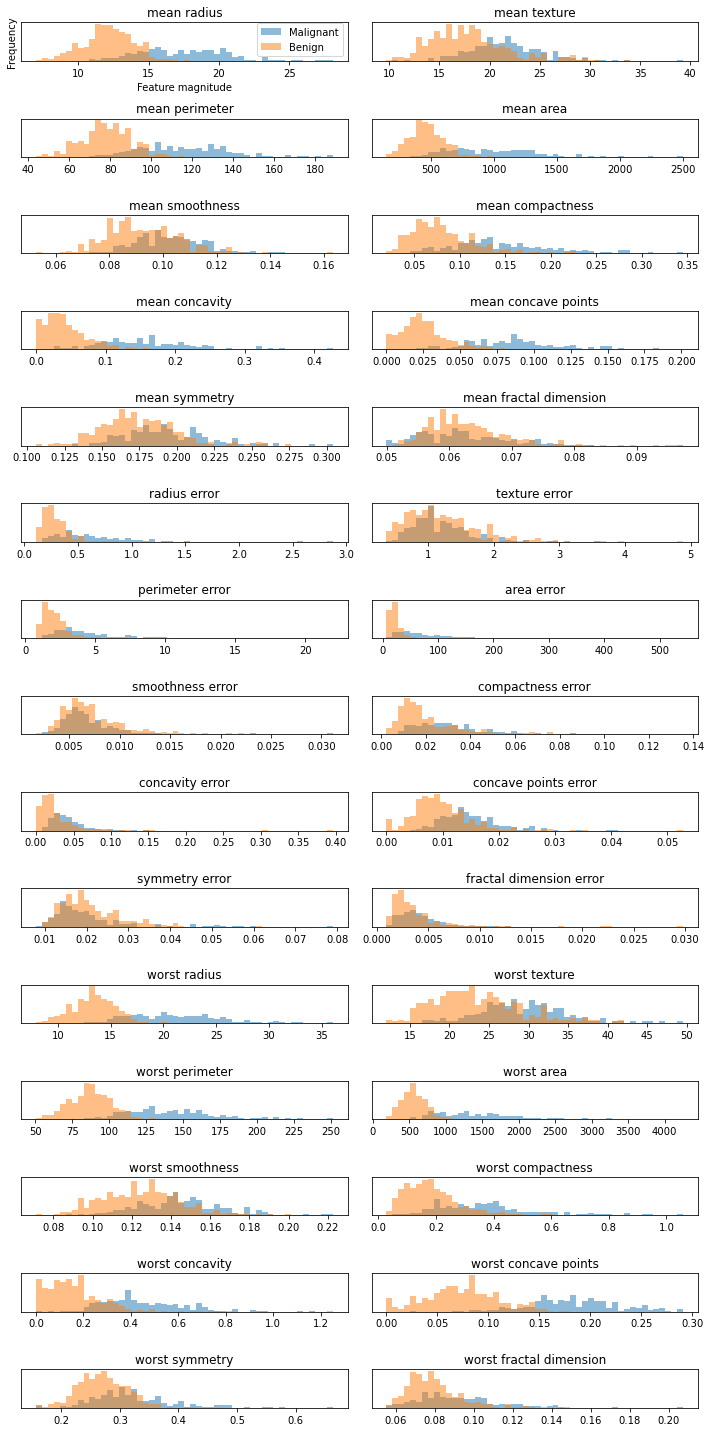

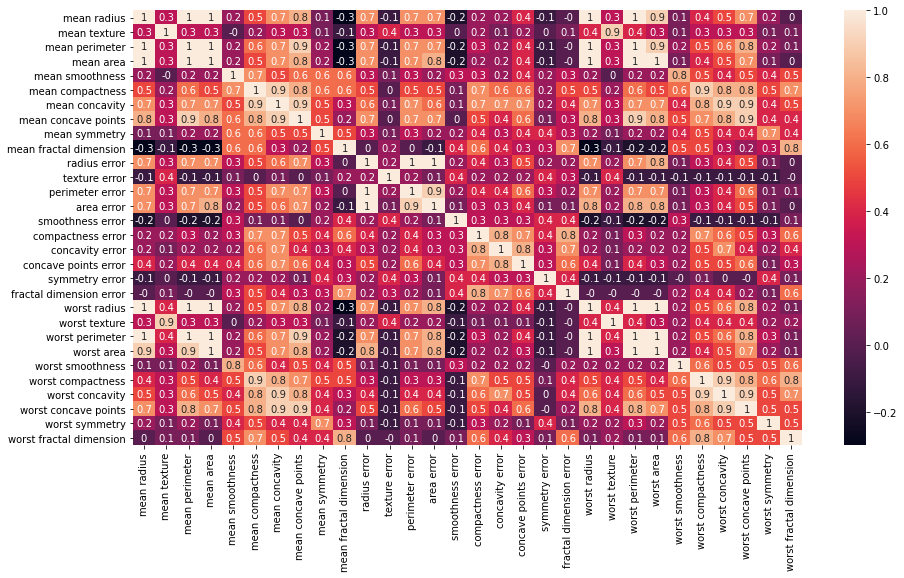

[ 1.33026664e+01  5.69238112e+00  2.83259341e+00  1.99126621e+00
  1.69095941e+00  1.19614372e+00  7.13037918e-01  5.77804918e-01
  5.14549644e-01  4.30579019e-01  3.58977964e-01 -1.91269450e-01
  2.86195387e-01 -1.59310961e-01 -1.38483045e-01  2.44786221e-01
 -8.79318674e-02  1.91811329e-01  1.70896266e-01 -7.17683028e-02
  1.39860289e-01  1.18721828e-01 -4.83194721e-02  8.92983892e-02
  6.81402316e-02  6.01968016e-02  3.31819744e-02  1.56432255e-02
 -1.61028757e-02 -6.50565973e-03]


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
cancer = load_breast_cancer()
import pandas as pd
# Making a data frame
cancerpd = pd.DataFrame(cancer.data, columns=cancer.feature_names)

fig, axes = plt.subplots(15,2,figsize=(10,20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]
ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:,i], bins =50)
    ax[i].hist(malignant[:,i], bins = bins, alpha = 0.5)
    ax[i].hist(benign[:,i], bins = bins, alpha = 0.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["Malignant", "Benign"], loc ="best")
fig.tight_layout()
plt.show()

import seaborn as sns
correlation_matrix = cancerpd.corr().round(1)
# use the heatmap function from seaborn to plot the correlation matrix
# annot = True to print the values inside the square
plt.figure(figsize=(15,8))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

#print eigvalues of correlation matrix
EigValues, EigVectors = np.linalg.eig(correlation_matrix)
print(EigValues)

## Discussing the correlation data

In the above example we note two things. In the first plot we display
the overlap of benign and malignant tumors as functions of the various
features in the Wisconsing breast cancer data set. We see that for
some of the features we can distinguish clearly the benign and
malignant cases while for other features we cannot. This can point to
us which features may be of greater interest when we wish to classify
a benign or not benign tumour.

In the second figure we have computed the so-called correlation
matrix, which in our case with thirty features becomes a $30\times 30$
matrix.

We constructed this matrix using **pandas** via the statements

In [4]:
cancerpd = pd.DataFrame(cancer.data, columns=cancer.feature_names)

and then

In [5]:
correlation_matrix = cancerpd.corr().round(1)

Diagonalizing this matrix we can in turn say something about which
features are of relevance and which are not. This leads  us to
the classical Principal Component Analysis (PCA) theorem with
applications. This will be discussed later this semester ([week 43](https://compphysics.github.io/MachineLearning/doc/pub/week43/html/week43-bs.html)).



## Other measures in classification studies: Cancer Data  again

(426, 30)
(143, 30)
Test set accuracy with Logistic Regression: 0.95
Test set accuracy Logistic Regression with scaled data: 0.96
[1.         1.         1.         1.         1.         1.
 1.         1.         0.92857143 0.92857143]
Test set accuracy with Logistic Regression  and scaled data: 0.96


/Users/MortenImac/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


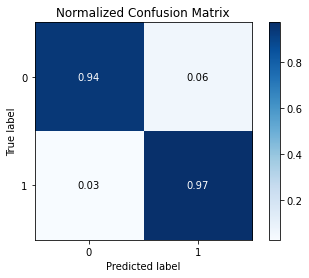

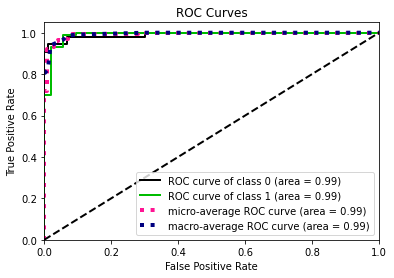

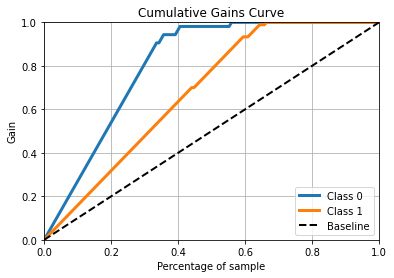

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
print("Test set accuracy with Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))
#now scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Logistic Regression
logreg.fit(X_train_scaled, y_train)
print("Test set accuracy Logistic Regression with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
#Cross validation
accuracy = cross_validate(logreg,X_test_scaled,y_test,cv=10)['test_score']
print(accuracy)
print("Test set accuracy with Logistic Regression  and scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))


import scikitplot as skplt
y_pred = logreg.predict(X_test_scaled)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()
y_probas = logreg.predict_proba(X_test_scaled)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()
skplt.metrics.plot_cumulative_gain(y_test, y_probas)
plt.show()